In [1]:
!pip install -q pyspellchecker # Spell Checker
!pip install -q ktrain # Training Framework
!pip install -q git+https://github.com/amaiya/eli5-tf # Explainability Module

In [2]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import string
import xgboost as xgb
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
import tensorflow as tf
import tensorflow.keras.backend as K
import lightgbm as lgb
import warnings
from PIL import Image
from spellchecker import SpellChecker
from tensorflow.keras import activations
from ktrain import vision

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
Task1_Train = pd.read_json("/kaggle/input/alta-datasetttt/training.json", lines=True)
Task1_Test = pd.read_json("/kaggle/input/alta-datasetttt/validation_data.json", lines=True)

In [4]:
Task1_Train.sample(1)

,text,label,id
7309,Most of our food is shipped in from the West C...,1,7309


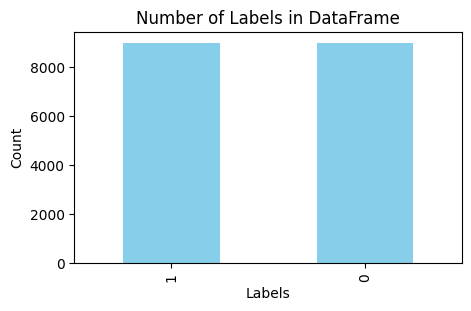

In [5]:
labels_counts = Task1_Train['label'].value_counts()

plt.figure(figsize=(5, 3))
labels_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Labels in DataFrame')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

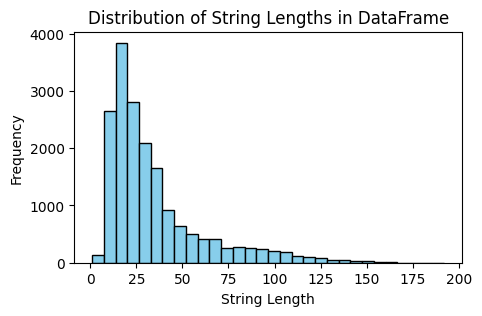

In [6]:
string_lengths = Task1_Train['text'].apply(lambda x: len(str(x).split())).values

# Plotting the string lengths
plt.figure(figsize=(5, 3))
plt.hist(string_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of String Lengths in DataFrame')
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.show()

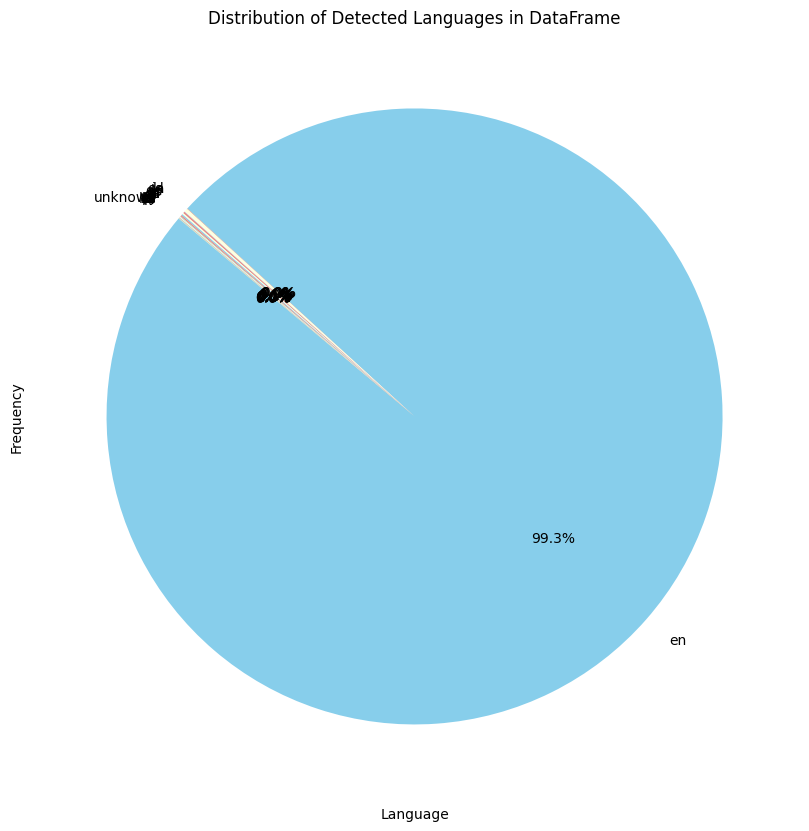

In [9]:
from langdetect import detect
from collections import Counter

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Create an array of detected languages
language_counts = Task1_Train['text'].apply(detect_language).values

# Count the occurrences of each language
language_counter = Counter(language_counts)


# Plotting the language counts
plt.figure(figsize=(15, 10))
plt.pie(language_counter.values(), labels=language_counter.keys(), autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'])
plt.title('Distribution of Detected Languages in DataFrame')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

In [10]:
language_counter

Counter({'en': 17877,
         'de': 32,
         'af': 14,
         'it': 13,
         'fr': 12,
         'ro': 12,
         'pt': 7,
         'da': 4,
         'es': 4,
         'no': 3,
         'cy': 3,
         'sv': 3,
         'id': 2,
         'ca': 2,
         'hr': 2,
         'cs': 2,
         'fi': 1,
         'pl': 1,
         'unknown': 1,
         'et': 1,
         'ko': 1,
         'ru': 1,
         'hi': 1,
         'nl': 1})

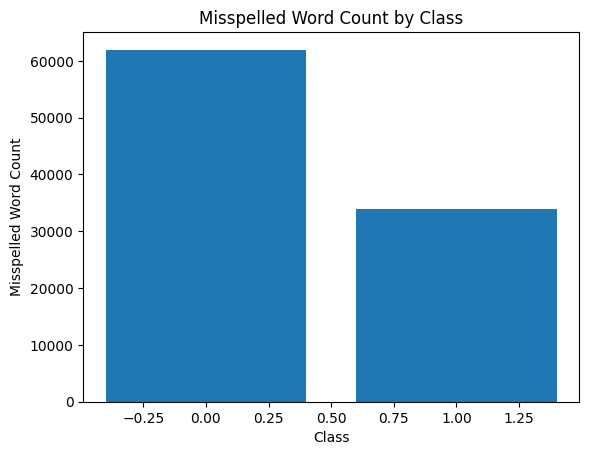

In [8]:
def count_misspelled_words(text):
    spell = SpellChecker()
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

# Apply the function to the 'text' column and create a new column 'misspelled_count'
Task1_Train['misspelled_count'] = Task1_Train['text'].apply(count_misspelled_words)

# Group by 'class' and sum the misspelled counts for each class
result_df = Task1_Train.groupby('label')['misspelled_count'].sum().reset_index()

# Plot the result using a bar chart
plt.bar(result_df['label'], result_df['misspelled_count'])
plt.xlabel('Class')
plt.ylabel('Misspelled Word Count')
plt.title('Misspelled Word Count by Class')
plt.show()

In [13]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F700-\U0001F77F"  # Alphanumeric Supplement
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(input_string):
    translator = str.maketrans('', '', string.punctuation)

    result = input_string.translate(translator)

    return result
def correct_spelling(input_text):
    try:
        # Create a SpellChecker object
        spell = SpellChecker()

        # Split the input text into words
        words = input_text.split()

        # Find misspelled words
        misspelled = spell.unknown(words)

        # Correct misspelled words
        corrected_text = " ".join(spell.correction(word) if word in misspelled else word for word in words)

        return corrected_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return input_text

hyperlink_pattern = r'https?://\S+|www\.\S+'

def PreProcessTweets(tweet):
  tweet2 = str(tweet)
  tweet2 = tweet2.replace("\n","")
  tweet2 = re.sub(hyperlink_pattern, '', tweet2)
  tweet2 = remove_emojis(tweet2)
  tweet2 = remove_punctuation(tweet2)
  tweet2 = correct_spelling(tweet2)
  return tweet2

Task1_Train['text'] = Task1_Train['text'].apply(lambda x: PreProcessTweets(x))
Task1_Test['text'] = Task1_Test['text'].apply(lambda x: PreProcessTweets(x))

# Training The Actual Model

### Feature Extraction Using CLS Token 

In [18]:
%%time
# Tokenize the text using RoBERTa tokenizer
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
bertmodel = AutoModel.from_pretrained('roberta-base').to(device)

text_embeddings = []
text_embeddings_test = []

for text in Task1_Train['text']:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length= 90)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        hidden_train = bertmodel(**inputs)
    cls_train = hidden_train.pooler_output.detach().cpu().numpy()
    text_embeddings.append(cls_train)

for text in Task1_Test['text']:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length= 90)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        hidden_train = bertmodel(**inputs)
    cls_train = hidden_train.pooler_output.detach().cpu().numpy()
    text_embeddings_test.append(cls_train)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 3min 11s, sys: 514 ms, total: 3min 12s
Wall time: 3min 12s


In [21]:
text_embeddings_numpy = np.concatenate(text_embeddings, axis = 0)
text_embeddings_numpy_test = np.concatenate(text_embeddings_test, axis = 0)

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings_numpy, Task1_Train['label'], test_size=0.3, random_state = 44)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = 44)

### XGBoost

In [24]:
from xgboost import XGBClassifier

# Train XGBoost model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [28]:
from sklearn.metrics import accuracy_score

# Make predictions on the validation set
y_valid_pred = model.predict(X_validation)

# Evaluate model on the validation set
accuracy_valid = accuracy_score(y_validation, y_valid_pred)
print(f'Validation Accuracy: {accuracy_valid}')

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {accuracy_test}')

Validation Accuracy: 0.9725925925925926
Test Accuracy: 0.9722222222222222


In [29]:
!nvidia-smi # Checking GPU

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Jan  5 20:30:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              31W / 250W |    832MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Transformer Based Models

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(Task1_Train['text'], Task1_Train['label'], test_size=0.3, random_state = 44)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = 44)

In [10]:
import ktrain
from ktrain import text

model_name = 'roberta-base'
TextTransformer = text.Transformer(model_name, maxlen = 90, classes = ['0','1'])
train = TextTransformer.preprocess_train(X_train.tolist(), y_train.tolist())
validation = TextTransformer.preprocess_test(X_validation.tolist(), y_validation.tolist())

model = TextTransformer.get_classifier()

learner = ktrain.get_learner(model, train_data=train, val_data=validation, batch_size=16)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 35
	95percentile : 96
	99percentile : 130


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 35
	95percentile : 95
	99percentile : 130


In [9]:
learner.autofit(2e-5, monitor ='val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/1024
788/788 [==============================] - 199s 221ms/step - loss: 0.2008 - accuracy: 0.9143 - val_loss: 0.0795 - val_accuracy: 0.9667
Epoch 2/1024
788/788 [==============================] - 169s 214ms/step - loss: 0.0764 - accuracy: 0.9725 - val_loss: 0.0604 - val_accuracy: 0.9774
Epoch 3/1024
788/788 [==============================] - 168s 214ms/step - loss: 0.0413 - accuracy: 0.9850 - val_loss: 0.0494 - val_accuracy: 0.9826
Epoch 4/1024
788/788 [==============================] - 168s 213ms/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.0666 - val_accuracy: 0.9815
Epoch 5/1024
788/788 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9930
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
788/788 [==========================

## Evaluation

In [10]:
learner.validate(class_names=TextTransformer.get_classes())

85/85 [==============================] - 15s 135ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1342
           1       0.98      0.98      0.98      1358

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



array([[1316,   26],
       [  21, 1337]])

In [11]:
learner.view_top_losses(n = 5, preproc=TextTransformer)

85/85 [==============================] - 11s 126ms/step
----------
id:850 | loss:6.67 | true:0 | pred:1)

----------
id:86 | loss:6.09 | true:0 | pred:1)

----------
id:1166 | loss:5.86 | true:1 | pred:0)

----------
id:1208 | loss:5.46 | true:0 | pred:1)

----------
id:603 | loss:5.09 | true:0 | pred:1)



## Explainability
###### Mainly Implemented Using LIME implemented with eli5

In [12]:
Sentence = 'College life is a transformative and unforgettable journey that marks a crucial chapter in the lives of many individuals. It\'s a period of self-discovery, academic challenges, and the formation of lifelong friendships. As students step onto the vibrant campuses, they are greeted not only by the towering academic buildings but also by a myriad of opportunities for personal and intellectual growth.'

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc = TextTransformer)

In [14]:
predictor.predict_proba(Sentence)

array([0.9371405 , 0.06285945], dtype=float32)

In [15]:
predictor.explain(Sentence)

In [23]:
predictor.explain(Task1_Train['text'][0])

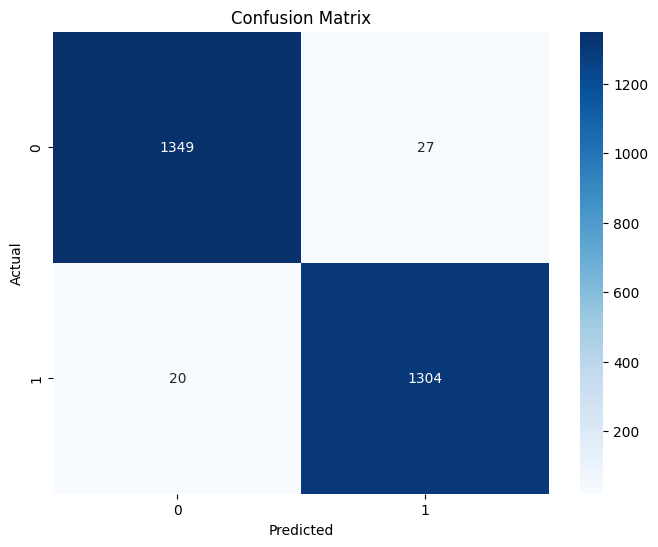

In [56]:
y_pred = predictor.predict(X_test.tolist(), return_proba=False)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_test.astype(str).values, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predictor.get_classes(), yticklabels=predictor.get_classes())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Evaluation metrics
accuracy = accuracy_score(y_test.astype(str).values, y_pred)
precision = precision_score(y_test.astype(str).values, y_pred, average='weighted')
recall = recall_score(y_test.astype(str).values, y_pred, average='weighted')
f1 = f1_score(y_test.astype(str).values, y_pred, average='weighted')

# Display the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test.astype(str).values, y_pred))

Accuracy: 0.9825925925925926
Precision: 0.9826073089151042
Recall: 0.9825925925925926
F1 Score: 0.9825933449735123

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1376
           1       0.98      0.98      0.98      1324

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



## Generating Predictions

In [ ]:
with open(model_name + '.json', 'w') as json_file:
    for i in range(len(Task1_Test)):
        pred = predictor.predict(str(Task1_Test['text'][i]))
        predictionsDictionary = {'index': int(Task1_Test['id'][i]), 'prediction': int(pred)}
        json.dump(predictionsDictionary, json_file)
        json_file.write('\n')

## Ensembling Via Hard Voting

In [ ]:
Roberta = pd.read_json("/content/submission.json", lines=True)
XLMRoberta = pd.read_json("/content/submission1.json", lines=True)
DistilBERT = pd.read_json("/content/submission2.json", lines=True)

In [ ]:
FinalPreds=[]
for i in range(len(Results1)):
  preds = {'0': 0, '1': 0}
  preds[str(Roberta['prediction'][i])] +=1
  preds[str(XLMRoberta['prediction'][i])] +=1
  preds[str(DistilBERT['prediction'][i])] +=1
  # Convert the dictionary to a list of tuples.
  list_of_tuples = list(preds.items())

  # Sort the list of tuples by the value of the tuple.
  sorted_list_of_tuples = sorted(list_of_tuples, key=lambda x: x[1])
  # Return the first element of the sorted list.
  key_of_largest_item = sorted_list_of_tuples[len(preds) - 1][0]
  FinalPreds.append(int(key_of_largest_item))

In [ ]:
with open('EnsembleApproach.json', 'w') as json_file:
    for i in range(len(Task1_Test)):
        predictionsDictionary = {'index': int(Task1_Test['id'][i]), 'prediction': int(FinalPreds[i])}
        json.dump(predictionsDictionary, json_file)
        json_file.write('\n')